<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg"  width=300, align="right">

In [ ]:
#@title **Identificação do Grupo**

#@markdown Integrantes do Grupo, nome completo em ordem alfabética (*informe \<RA\>,\<nome\>*)
Aluno1 = '10402412, Diego Oliveira Aluizio' #@param {type:"string"}
Aluno2 = '10396490, Jônatas Garcia de Oliveira' #@param {type:"string"}
Aluno3 = '10403046, Livia Alabarse dos Santos' #@param {type:"string"}
Aluno4 = '10403028, Marina Scabello Martin' #@param {type:"string"}
Aluno5 = '10265432, Pedro Henrique Araujo Farias' #@param {type:"string"}


In [ ]:
#@title Assinale aqui a sua opção de Projeto
Projeto = "IA Aplicada a Documentos: Uso de Grandes Modelos de Linguagem Abertos" #@param ["IA Aplicada a Imagens: Uso de Modelos de Redes Neurais", "IA Aplicada a Documentos: Uso de Grandes Modelos de Linguagem Abertos"]




# **Resumo**

O objetivo deste *notebook* é desenvolver o treinamento de um modelo para a classificação de textos com base em seu sentimento, podendo ser classificados como **positivo**, **neutro** ou **negativo**, tarefa conhecida como **análise de sentimento**. Os dados utilizados para treinamento do modelo são uma amostra do *dataset* **Tweet_Eleições_2022**. As bibliotecas e ferramentas de IA utilizadas foram a ***Transformers***, fornecida pela ***Hugging Face***, e o ***TensorFlow***, fornecido pela ***Google***. Como resultado, obtivemos um modelo com 89,85% de acurácia nos testes, que foi disponibilizado na plataforma do *Hugging Face*.

# **Bibliotecas utilizadas**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, create_optimizer

# **Apresentação dos dados**

Os dados utilizados foram obtidos a partir do *dataset* [Tweet_Eleições_2022](https://github.com/ciberdem/Tweets_Eleicoes_2022) (SILVA *et al*., 2024), que reúne aproximadamente 9,5 milhões de tweets coletados ao longo do processo eleitoral brasileiro de 2022, via API oficial do *X*, antigo *Twitter*.

Os dados foram pré-processados a partir das seguintes atividades: remoção de duplicatas, remoção de ruídos e anonimização de usuários, bem como seleção temporal, restringindo o conjunto à *tweets* publicados no dia 8 de janeiro de 2023. O resultado do pré-processamento foi um conjunto de 984 *tweets*.

Os integrantes do projeto realizaram anotação manual dos dados de acordo com o sentimento de cada *tweet* analisado. Você pode acessar a planilha de dados utilizados para treinamento neste [link](https://docs.google.com/spreadsheets/d/1wklfGXQpK6i5W9hOcYyIxT1BcdkuN-Ik/edit?usp=drive_link&ouid=102543127324810311691&rtpof=true&sd=true).

In [ ]:
import pandas as pd

tweets_file_id = "1wklfGXQpK6i5W9hOcYyIxT1BcdkuN-Ik"
url_tweets = f"https://drive.google.com/uc?id={tweets_file_id}"

df = pd.read_excel(url_tweets)
display(df)

,conversation_id,text,Sentimento
0,1612244481629117952,@user eu tenho pena das famílias vítimas de um...,NEGATIVO
1,1612263467028827904,O fato desse VAGABUNDO ter falado isso logo ap...,NEGATIVO
2,1612063785509854976,Os menos q chamaram bolsonaro de covarde por n...,NEGATIVO
3,1612180196127277056,"@user Esse rapaz é um empresário de BH, não ac...",NEUTRO
4,1612234907333411072,E essa palhaçada q tá acontecendo em Brasília ...,NEGATIVO
...,...,...,...
979,1612269945517120000,boa noite sweeties gostaria de avisar que moro...,NEUTRO
980,1612267702273309952,governadores de diferentes estados brasileiros...,NEUTRO
981,1612115088701360128,desta forma ela fara homenagem as mulheres pod...,NEUTRO
982,1612180057891520000,seria interessante se pudessemos num movimento...,NEUTRO


# **Preparação e transformação dos dados**

As únicas colunas interessantes para treinamento do modelo são `text` e `Sentimento`, portanto a coluna `conversation_id` será **removida**.

In [ ]:
df = df.drop('conversation_id', axis=1)
display(df)
print(f"\nDistribuição dos sentimentos:\n{df['Sentimento'].value_counts()}")

,text,Sentimento
0,@user eu tenho pena das famílias vítimas de um...,NEGATIVO
1,O fato desse VAGABUNDO ter falado isso logo ap...,NEGATIVO
2,Os menos q chamaram bolsonaro de covarde por n...,NEGATIVO
3,"@user Esse rapaz é um empresário de BH, não ac...",NEUTRO
4,E essa palhaçada q tá acontecendo em Brasília ...,NEGATIVO
...,...,...
979,boa noite sweeties gostaria de avisar que moro...,NEUTRO
980,governadores de diferentes estados brasileiros...,NEUTRO
981,desta forma ela fara homenagem as mulheres pod...,NEUTRO
982,seria interessante se pudessemos num movimento...,NEUTRO



Distribuição dos sentimentos:
Sentimento
NEGATIVO    358
POSITIVO    342
NEUTRO      284
Name: count, dtype: int64


Em seguida, realizamos o ***label encoding*** da coluna `Sentimento`, a qual representa nossa variável objetivo.

In [ ]:
label_map = {"POSITIVO": 0, "NEUTRO": 1, "NEGATIVO": 2}
df['sentimento'] = df['Sentimento'].map(label_map)
df = df.drop('Sentimento', axis=1)
display(df)

,text,sentimento
0,@user eu tenho pena das famílias vítimas de um...,2
1,O fato desse VAGABUNDO ter falado isso logo ap...,2
2,Os menos q chamaram bolsonaro de covarde por n...,2
3,"@user Esse rapaz é um empresário de BH, não ac...",1
4,E essa palhaçada q tá acontecendo em Brasília ...,2
...,...,...
979,boa noite sweeties gostaria de avisar que moro...,1
980,governadores de diferentes estados brasileiros...,1
981,desta forma ela fara homenagem as mulheres pod...,1
982,seria interessante se pudessemos num movimento...,1


Por fim, vamos separar os dados em **três conjuntos**:
- **Treinamento**: utilizados para aprendizagem do modelo durante o treinamento;
- **Validação**: utilizados para validação da aprendizagem do modelo durante o treinamento;
- **Teste**: utilizados para avaliação do modelo após o treinamento.

In [ ]:
train_val_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['sentimento']
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.25, random_state=42, stratify=train_val_df['sentimento']
)

In [ ]:
print(f"Tamanho do conjunto de Treino: {len(train_df)}")
display(train_df)

print(f"Tamanho do conjunto de Validação: {len(val_df)}")
display(val_df)

print(f"Tamanho do conjunto de Teste: {len(test_df)}")
display(test_df)

Tamanho do conjunto de Treino: 590


,text,sentimento
882,Se vc acha que a repressão à direita seria men...,2
33,Podem culpar por essa zona toda em Brasília e ...,2
756,o presidente do senado federal rodrigo pacheco...,1
786,a presidente do supremo tribunal federal decla...,1
875,Não curti Brasília. A única coisa que gostei f...,1
...,...,...
89,vamos brasileiros nao estou em brasilia mas me...,0
905,nao sou um velho eu juro kkkk vamos marcar sim...,0
487,"Eu creio num Deus vivo, justo e fiel, que honr...",0
920,tem gente com medo postando foto de mensagem p...,0


Tamanho do conjunto de Validação: 197


,text,sentimento
565,miguel mancio jornalista da agencia lusa acomp...,1
854,E sabe o que é mais pica? Que a polícia do DF ...,2
181,cercar brasilia cercar brasilia cercar brasili...,1
917,sinceramente se e tudo pago eu ia ser um infil...,0
315,nunca fui a brasilia mas meu coracao esta la e...,0
...,...,...
80,carnaval ja comecou em brasilia e a rapaziada ...,0
951,o povo chegando em que ter foco e objeto e lid...,1
703,O Brasileiro vai tirar o lula e ainda pode usa...,1
527,de volta a brasilia depois de merecidas ferias...,0


Tamanho do conjunto de Teste: 197


,text,sentimento
483,O bom de morar na fronteira é que é bem longe ...,0
255,a biblia e o livro mais maravilhoso que tem tu...,0
851,Oq mais me deixa chocada com a invasão no DF é...,2
768,brasil 08 01 2023 enquanto a tira o huck do ar...,1
908,o vei kk o carinha la da galocura falando q se...,0
...,...,...
650,obrigada ulliysses guimaraes hoje eu ofereco e...,0
886,apoio fazerem uma vaquinha pra ir a galocura e...,0
316,boa noite boa semana pra todos nos drleonardos...,0
447,"ISSO TEM QUE FAZER NO BRASIL,O EXÉRCITO TEVE M...",2


# **Configuração e Treinamento do Modelo**

## **Modelo pré-treinado**

O modelo pré-treinado utilizado para desenvolvimento do modelo deste *notebook* é o **BERTimbau Base**, um modelo baseado em BERT para análise de linguagem natural em português brasileiro.

## **BERTimbau: *Tokenizer* e *Encoding* dos dados**

Para utilizar o BERTimbau, precisamos utilizar também seu ***tokenizer*** para **converter texto em sequências de tokens** que o modelo BERTimbau entende, e vice-versa:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

A função `encode_texts` utiliza o ***tokenizer*** para preparar os dados para entrada no modelo BERTimbau, garantindo que todos tenham um comprimento fixo (max_len). Note que passamos `return_tensors='tf'` como argumento pois estamos utilizando o **TensorFlow**.

In [ ]:
def encode_texts(tokenizer, texts, max_len):
    return tokenizer(
        texts.tolist(),
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='tf'
    )

Aplicando o *encoding* aos conjuntos:

In [ ]:
MAX_LEN = 128

train_x = encode_texts(tokenizer, train_df['text'], MAX_LEN)
val_x = encode_texts(tokenizer, val_df['text'], MAX_LEN)
test_x = encode_texts(tokenizer, test_df['text'], MAX_LEN)

Transformando os dados e rótulos em pipelines de dados `tf.data` para serem alimentados no treinamento e avaliação pelo `TensorFlow`, embaralhando o conjunto de treinamento:

In [ ]:
train_y = train_df['sentimento'].to_numpy()
val_y = val_df['sentimento'].to_numpy()
test_y = test_df['sentimento'].to_numpy()

In [ ]:
train_dataset_dict = {key: train_x[key] for key in ['input_ids', 'attention_mask']}
val_dataset_dict = {key: val_x[key] for key in ['input_ids', 'attention_mask']}
test_dataset_dict = {key: test_x[key] for key in ['input_ids', 'attention_mask']}

In [ ]:
BATCH_SIZE = 32

train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_dataset_dict, train_y)).shuffle(len(train_df)).batch(BATCH_SIZE)
val_tf_dataset = tf.data.Dataset.from_tensor_slices((val_dataset_dict, val_y)).batch(BATCH_SIZE)
test_tf_dataset = tf.data.Dataset.from_tensor_slices((test_dataset_dict, test_y)).batch(BATCH_SIZE)

Note duas operações essenciais:
- `input_ids`: Mapeando para os tensores dos IDs dos tokens.
- `attention_mask`: Mapeando para os tensores das máscaras de atenção.

Esses mapeamentos são extremamente importantes para que o modelo compreenda e processe os dados.

## **BERTimbau: Carregando o Modelo**

Carregamos o modelo BERTimbau (`"neuralmind/bert-base-portuguese-cased"`) e definimos um **novo modelo**, utilizando o BERTimbau como modelo pré-treinado, adicionando uma camada de classificação no topo, ainda não treinada, com apenas **3 classificações possíveis** (`num_labels=3`), as quais classificarão o sentimento do texto analisado.

In [ ]:
MODEL_NAME = "neuralmind/bert-base-portuguese-cased"
id_to_label = {v: k for k, v in label_map.items()}

model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id_to_label,
    label2id=label_map
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Em seguida, **congelamos as camadas de *embedding*** e **8 camadas de *encoder*** do BERTimbau com **objetivo de impedir que os pesos dessas camadas sejam atualizados durante o processo de *fine-tuning***, preservando o conhecimento do BERTimbau e reduzindo o número de parâmetros a serem treinados, o que torna o treinamento deste modelo mais rápido.

In [ ]:
bert_main_layer = model.layers[0]
bert_main_layer.embeddings.trainable = False

NUM_LAYERS_TO_FREEZE = 8

if NUM_LAYERS_TO_FREEZE > 0 and hasattr(bert_main_layer, 'encoder'):
    print(f"Congelando as primeiras {NUM_LAYERS_TO_FREEZE} camadas do encoder BERT.")
    for i in range(NUM_LAYERS_TO_FREEZE):
        if i < len(bert_main_layer.encoder.layer):
            bert_main_layer.encoder.layer[i].trainable = False
            print(f"Encoder layer {i} congelada: {not bert_main_layer.encoder.layer[i].trainable}")
        else:
            print(f"Aviso: Tentativa de congelar camada {i}, mas o encoder tem apenas {len(bert_main_layer.encoder.layer)} camadas.")
            break
else:
    print("Nenhuma camada do encoder para congelar ou encoder não encontrado como esperado.")

Congelando as primeiras 8 camadas do encoder BERT.
Encoder layer 0 congelada: True
Encoder layer 1 congelada: True
Encoder layer 2 congelada: True
Encoder layer 3 congelada: True
Encoder layer 4 congelada: True
Encoder layer 5 congelada: True
Encoder layer 6 congelada: True
Encoder layer 7 congelada: True


Definindo alguns **hiperparâmetros** do modelo, como **número de épocas**, **taxa de aprendizagem** e **otimizador** utilizados:

In [ ]:
EPOCHS = 10
LEARNING_RATE = 2e-5

num_train_steps = (len(train_df) // BATCH_SIZE) * EPOCHS

optimizer, schedule = create_optimizer(
    init_lr=LEARNING_RATE,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01
)

Agora, vamos definir a função de perda a ser minimizada e sua métrica de desempenho. Por fim, compilamos o modelo.

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108923136 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 108925443 (415.52 MB)
Trainable params: 28944387 (110.41 MB)
Non-trainable params: 79981056 (305.10 MB)
_________________________________________________________________


Obs.: Algo importante de se comentar é o número de parâmetros na camada `dropout_75`. Essa camada não apresenta parâmetros a serem treinados, pois seu único propósito é **desligar aleatoriamente alguns neurônios da rede, evitando *overfitting***.

Como estávamos enfrentando **sérios problemas com *overfitting* durante o treinamento do modelo**, definimos também o ***early_stopping* e seus parâmetros**:

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## **Treinamento do Modelo**

Vamos, finalmente, treinar nosso modelo!

Explicando brevemente os argumentos utilizados na função `fit`:
- `train_df_dataset`: Utilizamos o conjunto de **treinamento** como *dataset* normalizado para treinamento pelo modelo;
- `validation_data=val_tf_dataset`: Utilizamos o `val_tf_dataset` como *dataset* normalizado para validação do treinamento do modelo;
- `epochs=EPOCHS`: Definimos o número de épocas, estabelecido como **10 épocas**;
- `batch_size=BATCH_SIZE`: Definimos o tamanho do lote para treinamento;
- `callbacks=[early_stopping]`: Passamos a nossa função de *Early Stopping* definida na célula anterior para evitar *overfitting*.

In [ ]:
history = model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)

Epoch 1/10
19/19 [==============================] - 29s 763ms/step - loss: 0.9849 - accuracy: 0.5322 - val_loss: 0.7703 - val_accuracy: 0.8071
Epoch 2/10
19/19 [==============================] - 12s 616ms/step - loss: 0.7256 - accuracy: 0.7746 - val_loss: 0.5877 - val_accuracy: 0.8325
Epoch 3/10
19/19 [==============================] - 11s 591ms/step - loss: 0.5939 - accuracy: 0.8068 - val_loss: 0.4736 - val_accuracy: 0.8528
Epoch 4/10
19/19 [==============================] - 11s 601ms/step - loss: 0.4912 - accuracy: 0.8525 - val_loss: 0.4003 - val_accuracy: 0.8528
Epoch 5/10
19/19 [==============================] - 11s 605ms/step - loss: 0.4164 - accuracy: 0.8610 - val_loss: 0.3750 - val_accuracy: 0.8629
Epoch 6/10
19/19 [==============================] - 11s 574ms/step - loss: 0.3675 - accuracy: 0.8831 - val_loss: 0.3399 - val_accuracy: 0.8782
Epoch 7/10
19/19 [==============================] - 12s 621ms/step - loss: 0.3467 - accuracy: 0.8949 - val_loss: 0.3343 - val_accuracy: 0.8782

# **Avaliação do modelo**



Com base nas informações de treinamento armazenadas na variável `history`, vamos plotar gráficos de *loss* e *acurácia* para avaliar o treinamento do modelo:

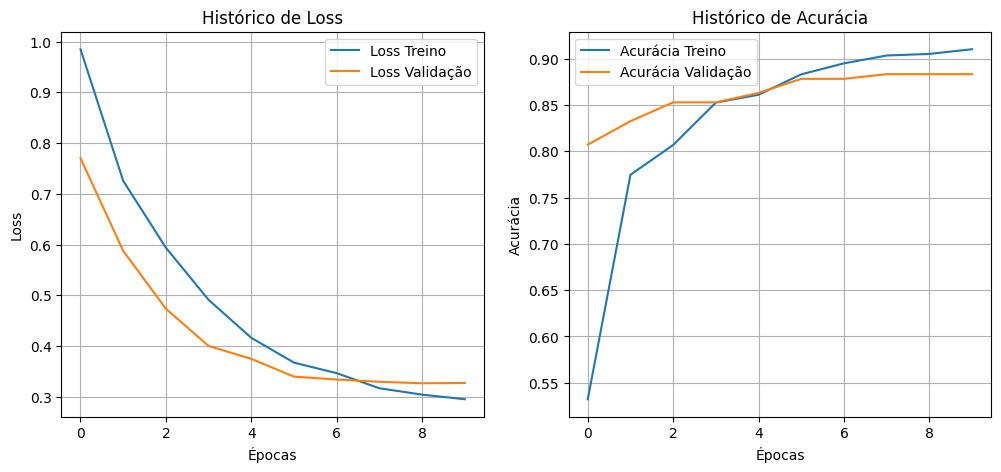

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.title('Histórico de Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.title('Histórico de Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.show()

Como é possível observar, o modelo apresenta ***loss* decrescente** para o **conjunto de treinamento**. Quanto ao **conjunto de validação**, a ***loss* decai até a sexta época**, onde acaba **estagnando até o fim do treinamento** (alerta para possível *overfitting*).

Quanto à acurácia, esta é **crescente tanto para o conjunto de treinamento quanto para o de validação**. Curiosamente, a **acurácia do conjunto de validação parte de valores muito altos**, iniciando acima de 80%. A mesma tendência a *overfitting* se observa no gráfico de acurácia.

Ainda que essa tendência seja recorrente, é importante observar que sua magnitude não se demonstra alarmante. Sendo assim, não é um modelo perfeito, mas também não é um modelo péssimo.

Dado a pequena quantidade de dados da amostra, consideramos satisfatórios os resultados apresentados nos gráficos de *loss* e *accuracy*;

In [ ]:
test_loss, test_accuracy = model.evaluate(test_tf_dataset, verbose=1)
print(f"Acurácia no Teste: {test_accuracy:.4f}")
print(f"Loss no Teste: {test_loss:.4f}")

7/7 [==============================] - 2s 250ms/step - loss: 0.3506 - accuracy: 0.8985
Acurácia no Teste: 0.8985
Loss no Teste: 0.3506


In [ ]:
predictions = model.predict(test_dataset_dict, batch_size=BATCH_SIZE)
predicted_logits = predictions.logits
predicted_labels_int = np.argmax(predicted_logits, axis=1)
target_names = [id_to_label[i] for i in range(3)]
print(classification_report(test_y, predicted_labels_int, target_names=target_names, digits=4))

7/7 [==============================] - 5s 246ms/step
              precision    recall  f1-score   support

    POSITIVO     0.9143    0.9412    0.9275        68
      NEUTRO     0.9020    0.8070    0.8519        57
    NEGATIVO     0.8816    0.9306    0.9054        72

    accuracy                         0.8985       197
   macro avg     0.8993    0.8929    0.8949       197
weighted avg     0.8988    0.8985    0.8975       197



Quanto ao *classification report*, o modelo apresenta bons valores para as métricas de *precision* e *recall* (> 80%). O ***f1-score***, particularmente, se mantém **acima de 85%**.

# **Consumo do Modelo**

## **Salvando o Modelo**

Para consumir o modelo em uma aplicação, inicialmente salvamos o modelo e realizamos o *download* dos arquivos com a intenção de realizar o *upload* no ***GitHub***, de modo que a aplicação acessasse o modelo localmente:

In [ ]:
OUTPUT_MODEL_DIR = "./modelo_sentimento_bertimbau_finetuned_tf"

model.save_pretrained(OUTPUT_MODEL_DIR)
tokenizer.save_pretrained(OUTPUT_MODEL_DIR)
print(f"Modelo e tokenizador salvos em: {OUTPUT_MODEL_DIR}")

Modelo e tokenizador salvos em: ./modelo_sentimento_bertimbau_finetuned_tf


Entretanto, por ser um arquivo muito grande, o **modelo não pôde ser enviado ao *GitHub***. Sendo assim, optamos por publicar o modelo na plataforma do ***Hugging Face***:

In [ ]:
!pip install -q huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
repo_id = "chrnphxbia/djmlp_tiny_analise_sentimento"

model.push_to_hub(
    repo_id,
    commit_message="Upload do modelo via Colab",
    private=False,
    create_repo=True
)

tokenizer.push_to_hub(
    repo_id,
    commit_message="Update do tokenizer via Colab",
    private=False
)

print(f"Modelo e tokenizador enviados para: https://huggingface.co/{repo_id}")

tf_model.h5:   0%|          | 0.00/436M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Modelo e tokenizador enviados para: https://huggingface.co/chrnphxbia/djmlp_tiny_analise_sentimento


## **Aplicação *Streamlit* para consumo do Modelo**

Desenvolvemos uma **aplicação *Streamlit*** que consome o modelo. Na aplicação, o usuário pode **inserir um texto para ser analisado**, ou **enviar um arquivo .xlsx ou .csv para analisar cada um dos textos do arquivo**, devendo **selecionar a coluna que apresenta os textos a serem analisados**.

Ao final da execução, **a aplicação apresenta o sentimento do texto analisado** e, caso tenha sido enviado um arquivo, **a aplicação permite que o usuário faça *download* de uma planilha com a coluna de sentimento definido adicionada**.

A aplicação foi hospedada no ***Streamlit Cloud*** e pode ser acessada neste [*link*](https://djlmpsentimentanalyzer.streamlit.app/).

O código-fonte da aplicação está hospedado no [repositório do projeto](https://github.com/chrnphxbia/djlmp_sentiment_analyzer).

# **Referências**

- Abadi, Martín et al. TensorFlow: Large-Scale Machine Learning on Heterogeneous Systems. 2015. Disponível em: https://www.tensorflow.org/. Acesso em: 01 jun. 2025.

- HUGGING FACE. Compartilhando modelos pré-treinados. Disponível em: https://huggingface.co/learn/llm-course/pt/chapter4/3. Acesso em: 1 jun. 2025.

- HUGGING FACE. Tokenizer. Disponível em: https://huggingface.co/docs/transformers/main_classes/tokenizer. Acesso em: 1 jun. 2025.

- HUGGING FACE. Uploading models. Disponível em: https://huggingface.co/docs/hub/models-uploading. Acesso em: 1 jun. 2025.

- SILVA, Luciano José da et al. Tweet_Eleições_2022: Um dataset de tweets durante as eleições presidenciais brasileiras de 2022. In: BRAZILIAN WORKSHOP ON SOCIAL NETWORK ANALYSIS AND MINING (BRASNAM), 13., 2024, Brasília/DF. Anais [...]. Porto Alegre: Sociedade Brasileira de Computação, 2024. p. 193-199. DOI 10.5753/brasnam.2024.1940. Disponível em: https://sol.sbc.org.br/index.php/brasnam/article/view/29343. Acesso em: 30 maio 2025.

- SOUZA, Fábio. neuralmind/bert-base-portuguese-cased. [S. l.]: Hugging Face, 2020. Disponível em: https://huggingface.co/neuralmind/bert-base-portuguese-cased. Acesso em: 1 jun. 2025.

- TALEBI, S. Fine-Tuning BERT for Text Classification (w/ Example Code). [Publicado em 17 de out. de 2024]. Disponível em: http://www.youtube.com/watch?v=4QHg8Ix8WWQ. Acesso em: 1 de jun. de 2025.

- WOLF, Thomas et al. HuggingFace's Transformers: State-of-the-art Natural Language Processing. CoRR, v. abs/1910.03771, 2019. Disponível em: http://arxiv.org/abs/1910.03771. Acesso em: 1 jun. 2025.





---

In [ ]:
# @title **Avaliação**
GitHub = 10 #@param {type:"slider", min:0, max:10, step:1}

Implementacao_Model_Code = 7 #@param {type:"slider", min:0, max:10, step:1}

Aplicacao_Streamlit = 9 #@param {type:"slider", min:0, max:10, step:1}

Texto_Artigo  = 6 #@param {type:"slider", min:0, max:10, step:1}

Video = 7 #@param {type:"slider", min:0, max:10, step:1}

Geral = 7 #@param {type:"slider", min:0, max:10, step:1}








In [ ]:
#@title **Nota Final**

nota = 2*GitHub + 4*Implementacao_Model_Code + 2*Aplicacao_Streamlit + 1*Texto_Artigo + 1*Video

nota = nota / 10

print(f'Nota final do trabalho {nota :.1f}')

import numpy as np
import pandas as pd

alunos = pd.DataFrame()

lista_tia = []
lista_nome = []

for i in range(1,6):
  exec("if Aluno" + str(i) + " !='None':  lista = Aluno" + str(i) + ".split(','); lista_tia.append(lista[0]); lista_nome.append(lista[1].upper())")

alunos['tia'] = lista_tia
alunos['nome'] = lista_nome
alunos['nota'] = np.round(nota,1)
print()
display(alunos)

Nota final do trabalho 7.9



,tia,nome,nota
0,1115665,ADRIANA FUJITA,7.9
1,1115677,DANIEL HENRIQUE,7.9
